In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import datetime as dtt

**Разделим датасет заказов на два года**

In [3]:
time_series = pd.read_csv('/content/time_series_data.csv')

In [4]:
time_serie_year_1 = time_series.head(358).copy()
time_serie_year_2 = time_series.tail(600-358).copy()

In [5]:
time_serie_year_1["FORECAST_DATE"] = pd.DatetimeIndex(time_serie_year_1["FORECAST_DATE"])
time_serie_year_2["FORECAST_DATE"] = pd.DatetimeIndex(time_serie_year_2["FORECAST_DATE"])

In [6]:
time_serie_year_1["day_of_week"] = time_serie_year_1["FORECAST_DATE"].dt.dayofweek
time_serie_year_2["day_of_week"] = time_serie_year_2["FORECAST_DATE"].dt.dayofweek

In [7]:
time_serie_year_2 = time_serie_year_2.reset_index().drop('index', axis = 1)

In [8]:
time_serie_year_1["time_shift"] = time_serie_year_1["FORECAST_DATE"] - time_serie_year_1["FORECAST_DATE"].shift(1)
time_serie_year_2["time_shift"] = time_serie_year_2["FORECAST_DATE"] - time_serie_year_2["FORECAST_DATE"].shift(1)

In [9]:
time_serie_year_1.loc[0, 'time_shift'] = time_serie_year_1.loc[1, 'time_shift']
time_serie_year_2.loc[0, 'time_shift'] = time_serie_year_2.loc[1, 'time_shift']

In [10]:
time_serie_year_1["time_shift"] = time_serie_year_1["time_shift"].apply(str).str.slice(0,1).apply(int)
time_serie_year_2["time_shift"] = time_serie_year_2["time_shift"].apply(str).str.slice(0,1).apply(int)

**Выделим пропущенные дни (выходные или другие поводы)**

In [11]:
time_serie_year_1[time_serie_year_1["time_shift"] != 1]

,FORECAST_DATE,num_of_orders,entropy,day_of_week,time_shift
3,2022-01-08,14,1.973001,5,2
62,2022-03-09,102,3.587194,2,2
115,2022-05-02,38,3.245126,0,2
122,2022-05-10,70,3.491968,1,2


In [12]:
time_serie_year_2[time_serie_year_2["time_shift"] != 1]

,FORECAST_DATE,num_of_orders,entropy,day_of_week,time_shift
3,2023-01-08,556,5.233543,6,2
124,2023-05-10,1127,5.464009,2,2


In [13]:
time_serie_year_1.shift(1)[time_serie_year_1["time_shift"] != 1]

,FORECAST_DATE,num_of_orders,entropy,day_of_week,time_shift
3,2022-01-06,17.0,2.197225,3.0,1.0
62,2022-03-07,23.0,2.302585,0.0,1.0
115,2022-04-30,63.0,3.331965,5.0,1.0
122,2022-05-08,43.0,3.319493,6.0,1.0


In [14]:
time_serie_year_2.shift(1)[time_serie_year_2["time_shift"] != 1]

,FORECAST_DATE,num_of_orders,entropy,day_of_week,time_shift
3,2023-01-06,157.0,4.290630,4.0,1.0
124,2023-05-08,391.0,5.017094,0.0,1.0


**Введем фиктивные записи с нулем заказов и нулем энтропии**

In [15]:
first_append = [pd.to_datetime('2022-01-07', format = '%Y-%m-%d'), 0, 0, 4, 1]
second_append = [pd.to_datetime('2022-03-08', format = '%Y-%m-%d'), 0, 0, 1, 1]
third_append = [pd.to_datetime('2022-05-01', format = '%Y-%m-%d'), 0, 0, 6, 1]
fourth_append = [pd.to_datetime('2022-05-09', format = '%Y-%m-%d'), 0, 0, 0, 1]

time_serie_year_1.loc[2.5] = first_append
time_serie_year_1.loc[61.5] = second_append
time_serie_year_1.loc[114.5] = third_append
time_serie_year_1.loc[121.5] = fourth_append

time_serie_year_1 = time_serie_year_1.sort_index().reset_index(drop=True)

In [16]:
first_append = [pd.to_datetime('2023-01-07', format = '%Y-%m-%d'), 0, 0, 5, 1]
second_append = [pd.to_datetime('2023-05-09', format = '%Y-%m-%d'), 0, 0, 1, 1]

In [17]:
time_serie_year_2.loc[2.5] = first_append
time_serie_year_2.loc[123.5] = second_append

In [18]:
time_serie_year_2 = time_serie_year_2.sort_index().reset_index(drop=True)

In [19]:
time_serie_year_1["time_shift"] = time_serie_year_1["FORECAST_DATE"] - time_serie_year_1["FORECAST_DATE"].shift(1)
time_serie_year_2["time_shift"] = time_serie_year_2["FORECAST_DATE"] - time_serie_year_2["FORECAST_DATE"].shift(1)

In [20]:
time_serie_year_1 = time_serie_year_1.drop(["time_shift"], axis = 1)
time_serie_year_2 = time_serie_year_2.drop(["time_shift"], axis = 1)

In [21]:
time_serie_year_1[time_serie_year_1["num_of_orders"] == 0]

,FORECAST_DATE,num_of_orders,entropy,day_of_week
3,2022-01-07,0,0.0,4
63,2022-03-08,0,0.0,1
117,2022-05-01,0,0.0,6
125,2022-05-09,0,0.0,0


In [22]:
time_serie_year_2[time_serie_year_2["num_of_orders"] == 0]

,FORECAST_DATE,num_of_orders,entropy,day_of_week
3,2023-01-07,0,0.0,5
125,2023-05-09,0,0.0,1


**Заполним фиктивные записи некоторыми минимальными значениями, все равно они будут указаны как выходные в Prophet**

In [24]:
number_of_couriers_series_year_1 = np.array(time_serie_year_1['num_of_orders'])
entropies_series_year_1 = np.array(time_serie_year_1['entropy'])
number_of_couriers_series_year_2 = np.array(time_serie_year_2['num_of_orders'])
entropies_series_year_2 = np.array(time_serie_year_2['entropy'])

In [25]:
entropies_series_year_1[entropies_series_year_1 == 0] = entropies_series_year_1[entropies_series_year_1 != 0].min()
entropies_series_year_1[np.isnan(entropies_series_year_1)] = entropies_series_year_1[~np.isnan(entropies_series_year_1)].min()
number_of_couriers_series_year_1[number_of_couriers_series_year_1 == 0] = 2
number_of_couriers_series_year_1[number_of_couriers_series_year_1 == 1] = 2

In [26]:
number_of_couriers_series_year_2[number_of_couriers_series_year_2 == 0] = 2
number_of_couriers_series_year_2[number_of_couriers_series_year_2 == 1] = 2


In [27]:
entropies_series_year_2[entropies_series_year_2 == 0] = entropies_series_year_2[(np.where(entropies_series_year_2 == 0)[0] + 7)]

In [28]:
time_serie_year_1['num_of_orders'] = number_of_couriers_series_year_1
time_serie_year_2['num_of_orders'] = number_of_couriers_series_year_2

time_serie_year_1['entropy'] = entropies_series_year_1
time_serie_year_2['entropy'] = entropies_series_year_2

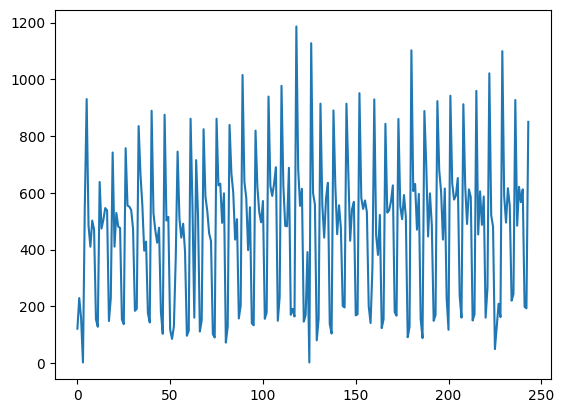

In [29]:
plt.plot(number_of_couriers_series_year_2)

**Проведем тест на нормальность временного ряда**

In [30]:
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score

In [ ]:
test_stats =  ['JB', 'p-value', 'skew', 'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(number_of_couriers_series_year_2)
a = np.vstack([jb_test])
res_of_test = SimpleTable(a, test_stats)
print(res_of_test)

        JB              p-value              skew            kurtosis     
--------------------------------------------------------------------------
5.706177327675081 0.05766593484180449 0.247780473887435 2.4381435318996334
--------------------------------------------------------------------------


**Эксцесс близок, а ассиметрия присутствует, тест на нормальность не пройден**

**Но зато ряд стационарный**

In [ ]:
adf_test = sm.tsa.adfuller(number_of_couriers_series_year_2)
print( 'adf: ', adf_test[0] )
print( 'p-value: ', adf_test[1])
print('Critical values: ', adf_test[4])
if adf_test[0]> adf_test[4]['5%']:
    print('nonstationary')
else:
    print('stationary')

adf:  -2.930146573562279
p-value:  0.04195299776525335
Critical values:  {'1%': -3.4592326027153493, '5%': -2.8742454699025872, '10%': -2.5735414688888465}
stationary


**Посмотрим на автокорреляции**

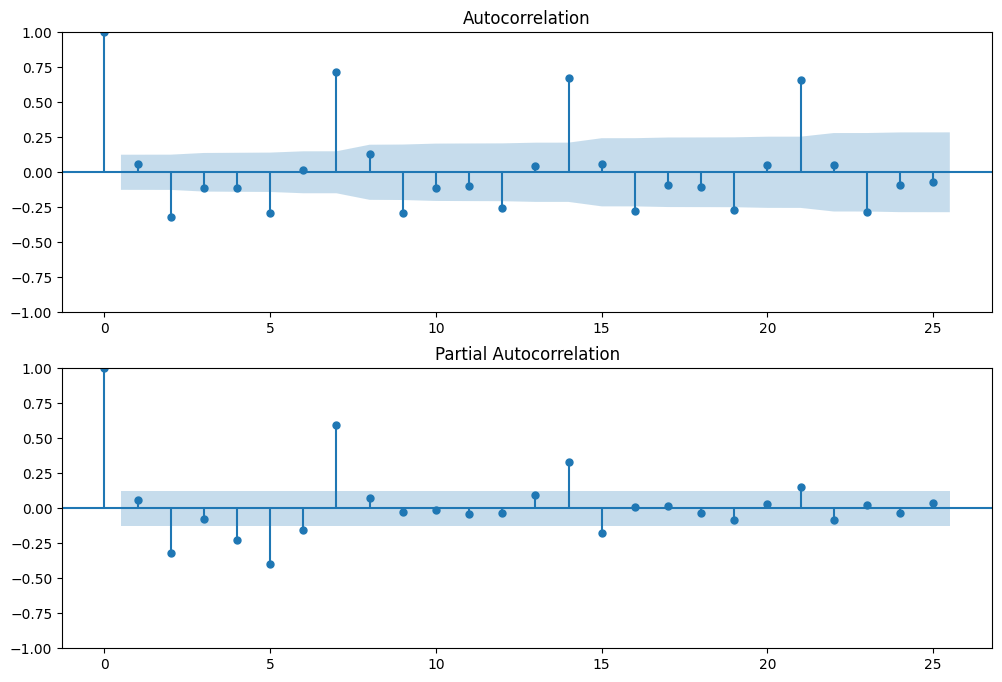

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(number_of_couriers_series_year_2, lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(number_of_couriers_series_year_2, lags=25, ax=ax2)

**Что и ожидалось, лучшим предиктором является тот же день предыдушей недели**

In [31]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Установим Prophet и предскажем наш временной ряд**

In [ ]:
!pip install prophet

In [32]:
time_serie_year_2

,FORECAST_DATE,num_of_orders,entropy,day_of_week
0,2023-01-04,121,3.964837,2
1,2023-01-05,229,4.242058,3
2,2023-01-06,157,4.290630,4
3,2023-01-07,2,4.402691,5
4,2023-01-08,556,5.233543,6
...,...,...,...,...
239,2023-08-31,567,4.985495,3
240,2023-09-01,612,5.233561,4
241,2023-09-02,198,4.318521,5
242,2023-09-03,193,4.373321,6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_xkv9x2/ft7m9zlu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_xkv9x2/zwfxi8ee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58273', 'data', 'file=/tmp/tmp9_xkv9x2/ft7m9zlu.json', 'init=/tmp/tmp9_xkv9x2/zwfxi8ee.json', 'output', 'file=/tmp/tmp9_xkv9x2/prophet_modeliph5hmdd/prophet_model-20230913224812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mape =  14.172541184999949 %


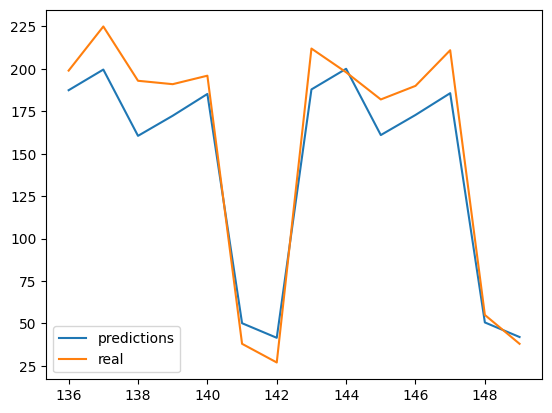

In [ ]:
from prophet import Prophet


known_holidays_y1 = pd.DataFrame({
    'holiday': 'known_holiday',
    'ds': [pd.to_datetime('2022-01-07'), pd.to_datetime('2022-03-08'),pd.to_datetime('2022-05-01'), pd.to_datetime('2022-05-09')]
})

model_y1 = Prophet(holidays = known_holidays_y1)
year_1_df_for_prophet = time_serie_year_1[["FORECAST_DATE", "num_of_orders", 'entropy']][150:300].reset_index()
year_1_df_for_prophet = year_1_df_for_prophet.rename(columns={'FORECAST_DATE' : 'ds', 'num_of_orders': 'y'})

forecast_horizon = 14

model_y1.fit(year_1_df_for_prophet[:-forecast_horizon])


future_y1 = model_y1.make_future_dataframe(periods=forecast_horizon)

forecast_y1 = model_y1.predict(future_y1)
predictions_y1 = forecast_y1['yhat']
plt.plot(predictions_y1[-forecast_horizon:], label = 'predictions')
plt.plot(year_1_df_for_prophet["y"][-forecast_horizon:], label = 'real')
plt.legend()
print('mape = ',mape(year_1_df_for_prophet["y"][-forecast_horizon:], predictions_y1[-forecast_horizon:]), '%')

In [ ]:
errors_days_prior_y1 = []
for i in range(14):
  errors_days_prior_y1.append(mape(year_1_df_for_prophet["y"][-14+i:], predictions_y1[-14+i:]))

**Бизнесу очень интерестно как рано мы сможем получить точный прогноз**

Text(0, 0.5, 'mape in %')

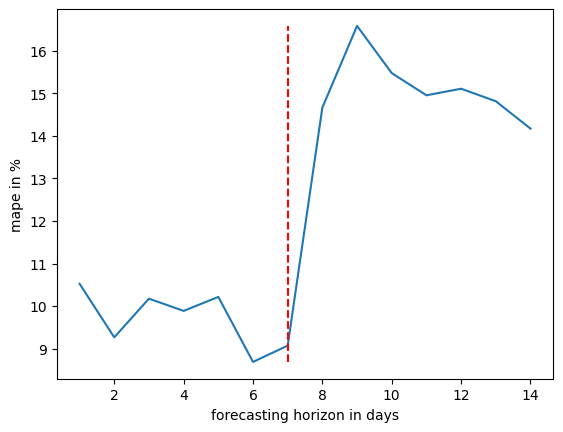

In [ ]:
plt.plot(np.arange(14) + 1, errors_days_prior_y1[::-1])
plt.xlabel('forecasting horizon in days')
plt.vlines((7), ymin = min(errors_days_prior_y1), ymax = max(errors_days_prior_y1), color = 'r', linestyles = 'dashed')
plt.ylabel('mape in %')

**Легко видеть что наибольшая точность достигается примерно за неделю до обозначенной даты**


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_xkv9x2/sibbzux0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_xkv9x2/95q56m0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91158', 'data', 'file=/tmp/tmp9_xkv9x2/sibbzux0.json', 'init=/tmp/tmp9_xkv9x2/95q56m0l.json', 'output', 'file=/tmp/tmp9_xkv9x2/prophet_modelqhjjco3t/prophet_model-20230913225208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mape =  10.160530782011692 %


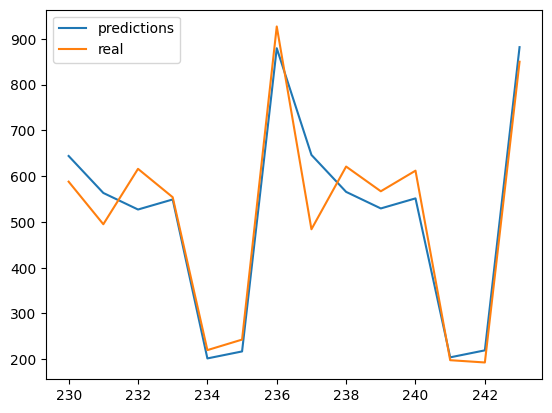

In [ ]:
known_holidays_y2 = pd.DataFrame({
    'holiday': 'known_holiday',
    'ds': [pd.to_datetime('2023-01-07'), pd.to_datetime('2023-05-09')]
})

model_y2 = Prophet(holidays = known_holidays_y2)
year_2_df_for_prophet = time_serie_year_2[["FORECAST_DATE", "num_of_orders", 'entropy']]
year_2_df_for_prophet = year_2_df_for_prophet.rename(columns={'FORECAST_DATE' : 'ds', 'num_of_orders': 'y'})

forecast_horizon = 14

model_y2.fit(year_2_df_for_prophet[:-forecast_horizon])


future_y2 = model_y2.make_future_dataframe(periods=forecast_horizon)

forecast_y2 = model_y2.predict(future_y2)
predictions_y2 = forecast_y2['yhat']
plt.plot(predictions_y2[-forecast_horizon:], label = 'predictions')
plt.plot(year_2_df_for_prophet["y"][-forecast_horizon:], label = 'real')
plt.legend()
print('mape = ',mape(year_2_df_for_prophet["y"][-forecast_horizon:], predictions_y2[-forecast_horizon:]), '%')

In [ ]:
errors_days_prior_y2 = []
for i in range(14):
  errors_days_prior_y2.append(mape(year_2_df_for_prophet["y"][-14+i:], predictions_y2[-14+i:]))


Text(0, 0.5, 'mape in %')

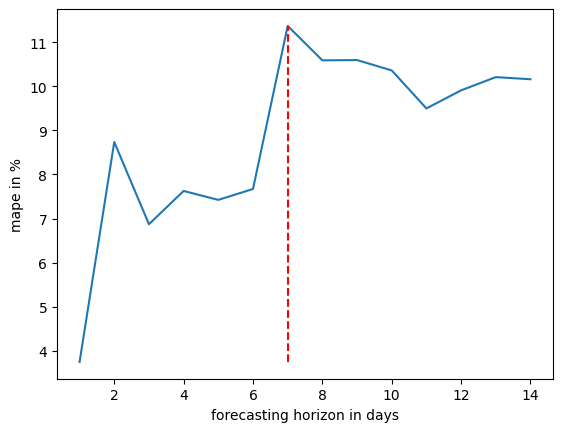

In [ ]:
plt.plot(np.arange(14) + 1, errors_days_prior_y2[::-1])
plt.vlines((7), ymin = min(errors_days_prior_y2), ymax = max(errors_days_prior_y2), color = 'r', linestyles = 'dashed')
plt.xlabel('forecasting horizon in days')
plt.ylabel('mape in %')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_xkv9x2/f61ijb23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_xkv9x2/oa2mse6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13107', 'data', 'file=/tmp/tmp9_xkv9x2/f61ijb23.json', 'init=/tmp/tmp9_xkv9x2/oa2mse6s.json', 'output', 'file=/tmp/tmp9_xkv9x2/prophet_modeltkk8l7ag/prophet_model-20230913225240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mape =  5.360127194042152 %


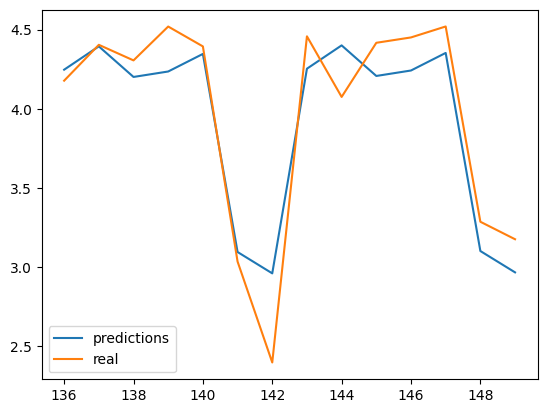

In [ ]:
known_holidays_y1 = pd.DataFrame({
    'holiday': 'known_holiday',
    'ds': [pd.to_datetime('2022-01-07'), pd.to_datetime('2022-03-08'),pd.to_datetime('2022-05-01'), pd.to_datetime('2022-05-09')]
})

model_y1_e = Prophet(holidays = known_holidays_y1)
year_1_df_for_prophet_e = time_serie_year_1[["FORECAST_DATE", "num_of_orders", 'entropy']][150:300].reset_index()
year_1_df_for_prophet_e = year_1_df_for_prophet_e.rename(columns={'FORECAST_DATE' : 'ds', 'entropy': 'y'})

forecast_horizon = 14

model_y1_e.fit(year_1_df_for_prophet_e[:-forecast_horizon])


future_y1_e = model_y1_e.make_future_dataframe(periods=forecast_horizon)

forecast_y1_e = model_y1_e.predict(future_y1_e)
predictions_y1_e = forecast_y1_e['yhat']
plt.plot(predictions_y1_e[-forecast_horizon:], label = 'predictions')
plt.plot(year_1_df_for_prophet_e["y"][-forecast_horizon:], label = 'real')
plt.legend()
print('mape = ',mape(year_1_df_for_prophet_e["y"][-forecast_horizon:], predictions_y1_e[-forecast_horizon:]), '%')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_xkv9x2/qjxoe4kt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_xkv9x2/1czigv4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67493', 'data', 'file=/tmp/tmp9_xkv9x2/qjxoe4kt.json', 'init=/tmp/tmp9_xkv9x2/1czigv4m.json', 'output', 'file=/tmp/tmp9_xkv9x2/prophet_modelubpgx806/prophet_model-20230913225242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mape =  3.2443421626293474 %


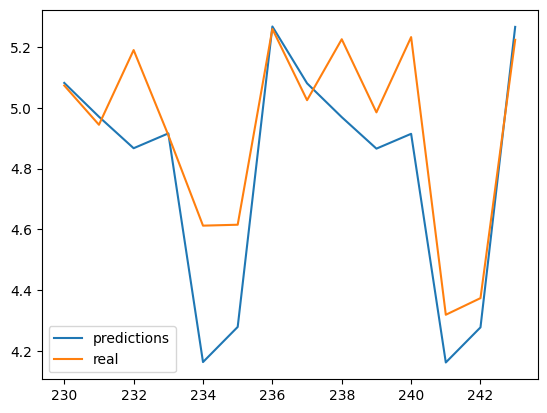

In [ ]:
known_holidays_y2 = pd.DataFrame({
    'holiday': 'known_holiday',
    'ds': [pd.to_datetime('2023-01-07'), pd.to_datetime('2023-05-09')]
})

model_y2_e = Prophet(holidays = known_holidays_y2)
year_2_df_for_prophet_e = time_serie_year_2[["FORECAST_DATE", "num_of_orders", 'entropy']]
year_2_df_for_prophet_e = year_2_df_for_prophet_e.rename(columns={'FORECAST_DATE' : 'ds', 'entropy': 'y'})

forecast_horizon = 14

model_y2_e.fit(year_2_df_for_prophet_e[:-forecast_horizon])


future_y2_e = model_y2_e.make_future_dataframe(periods=forecast_horizon)

forecast_y2_e = model_y2_e.predict(future_y2)
predictions_y2_e = forecast_y2_e['yhat']
plt.plot(predictions_y2_e[-forecast_horizon:], label = 'predictions')
plt.plot(year_2_df_for_prophet_e["y"][-forecast_horizon:], label = 'real')
plt.legend()
print('mape = ',mape(year_2_df_for_prophet_e["y"][-forecast_horizon:], predictions_y2_e[-forecast_horizon:]), '%')